# Automatic Text Generaion

This program runs on a corpus of homogeneous document of textual content and automatically generates similar text from a given seed. Specifically, we apply on a set of 5000 user Amazon reviews on a product. There are three  sequential modeling techniques to be chosen from - RNN, LSTM< and GRU.

In [1]:
import numpy as np
import sys

# to print all in a large list avoiding "..."
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
# modeling parameters

EMBEDDING_DIMENSION = 300
RNN_OUTPUT_DIMENSION = 50
MEMORY_LENGTH = 25
EPOCHS = 25
BATCH_SIZE = 1024
TRAIN_PERCENT = 0.7
VERBOSE_MODE = True
SAVE_MODEL = True
SAVED_MODEL = './models/review_model_lstm.h5'

In [3]:
# Read the review file

import pandas as pd

#data = pd.read_csv('./data/Amazon Reviews - Fire HD 8 Tablet - 200.csv') # for development
data = pd.read_csv('Amazon Reviews - Fire HD 8 Tablet - 5000.csv')
print(data.head())

# Extract abstracts
all_reviews = list(data['Body'])
print("Number of Reviews: ", len(all_reviews))

# test print and cross check
print(data['Body'][3])
print(all_reviews[3])

                                                  ID  \
0  Review: 4736 : Amazon.com: Customer reviews: F...   
1  Review: 2571 : Amazon.com: Customer reviews: F...   
2  Review: 1356 : Amazon.com: Customer reviews: F...   
3  Review: 573 : Amazon.com: Customer reviews: Fi...   
4  Review: 43 : Amazon.com: Customer reviews: Fir...   

                           Date  \
0  Tue Apr 16 00:00:00 EDT 2019   
1  Sat Oct 27 00:00:00 EDT 2018   
2  Tue Nov 13 00:00:00 EST 2018   
3  Fri Nov 09 00:00:00 EST 2018   
4  Sat Oct 06 00:00:00 EDT 2018   

                                                Body  
0  I like that it has a feature that lets you set...  
1  I returned this tablet for the simple fact tha...  
2  I guess you get whatcha pay for. I thought, wi...  
3  I had the Kindle Fire HDX 8.9. It had so many ...  
4  Sound is tiny and extremely difficult to keep ...  
Number of Reviews:  5000
I had the Kindle Fire HDX 8.9. It had so many more apps. One which I truly miss is, Optimum to go

In [ ]:
all_reviews = all_reviews[:2500]

C:\Users\Divyanshu\AppData\Local\Programs\Python\Python310\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\Divyanshu\AppData\Local\Programs\Python\Python310\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


                                                  ID  \
0  Review: 4736 : Amazon.com: Customer reviews: F...   
1  Review: 2571 : Amazon.com: Customer reviews: F...   
2  Review: 1356 : Amazon.com: Customer reviews: F...   
3  Review: 573 : Amazon.com: Customer reviews: Fi...   
4  Review: 43 : Amazon.com: Customer reviews: Fir...   

                           Date  \
0  Tue Apr 16 00:00:00 EDT 2019   
1  Sat Oct 27 00:00:00 EDT 2018   
2  Tue Nov 13 00:00:00 EST 2018   
3  Fri Nov 09 00:00:00 EST 2018   
4  Sat Oct 06 00:00:00 EDT 2018   

                                                Body        yymm  
0  I like that it has a feature that lets you set...   (2019, 4)  
1  I returned this tablet for the simple fact tha...  (2018, 10)  
2  I guess you get whatcha pay for. I thought, wi...  (2018, 11)  
3  I had the Kindle Fire HDX 8.9. It had so many ...  (2018, 11)  
4  Sound is tiny and extremely difficult to keep ...  (2018, 10)  


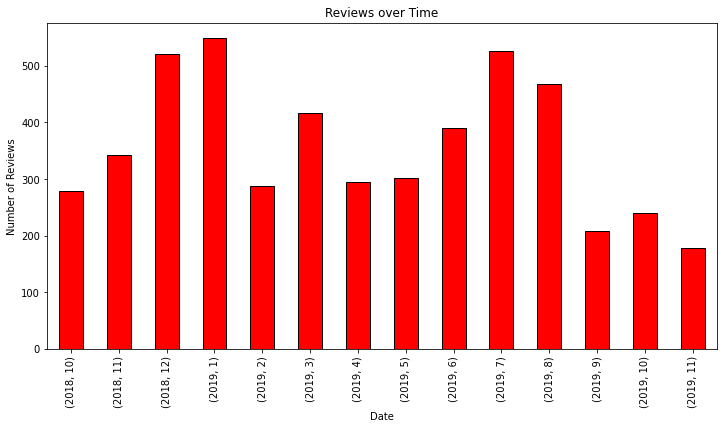

In [4]:
# Plot the frequency of reviews on a monthly basis

import matplotlib.pyplot as plt
%matplotlib inline

data['yymm'] = [
    (year, month) for year, month in zip(
        pd.DatetimeIndex(data['Date']).year, pd.DatetimeIndex(data['Date']).month)
]

monthly = data.groupby('yymm')['ID'].count().plot.bar(
    color='red', edgecolor='k', figsize=(12, 6))

plt.ylabel('Number of Reviews')
plt.xlabel('Date')
plt.title('Reviews over Time')

print(data.head())

In [ ]:
# Load the text analysis package aText

# To install aText: "conda env list" to list all conda environment
# "activate py37" to activate your favorite environment
# "pip install atext"

import aText

# kill the spawned JVM process once done with aText, else it will continue to running in the background
aText.stop_atext()

# first usage of aText takes time to download some necessary files
# make sure to have write permission for the Lib/site-package directory
aText.start_atext()
aText.test()

# from py4j.java_gateway import JavaGateway
# gateway = JavaGateway()                 # connect to the JV
# misc_app = gateway.entry_point          # get the an application instance

# data['sentiment'] = [misc_app.sentiment(text)[0] for text in data['Body']]

aText stopped


In [ ]:
# Plot the overall sentiment in reviews on a monthly basis

monthly = data.groupby('yymm') \
    .agg({'sentiment':'mean', 'ID':'size'})\
    .rename(columns={'sentiment':'avg_sent','ID':'count'}) 
    #.reset_index()
print(monthly)

#monthly['sentiment'].plot.bar(color='red', edgecolor='k', figsize=(12, 6))

freq_series = pd.Series(monthly['avg_sent'])

plt.figure(edgecolor='k', figsize=(12, 8))
ax = freq_series.plot(kind = 'bar')
ax.set_ylabel('Monthly Average Sentiment Level')
ax.set_xlabel('Year & Month')
ax.set_title('Monthly Sentiment Chart')

rects = ax.patches

for rect, label in zip(rects, monthly['count']):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')

In [5]:
# For word embedding, either train with the corpus of reviews or load a pretrained model from Google

import gensim
from gensim.models import Word2Vec

# Load Google's pre-trained Word2Vec, this takes a minute or two
model_path = 'GoogleNews-vectors-negative300.bin'
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True) 
    
# Training
# size: The number of dimensions of the embeddings and the default is 100.
# window: The maximum distance between a target word and words around the target word. The default window is 5.
# min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
# workers: The number of partitions during training and the default workers is 3.
# sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

#word2vec_model = Word2Vec(review_sentences, size=100, window=50, min_count=1, workers=4, sg=1)
#word2vec_model.save("./models/word2vec.model")

In [11]:
word2vec_model.key_to_index

{'</s>': 0,
 'in': 1,
 'for': 2,
 'that': 3,
 'is': 4,
 'on': 5,
 '##': 6,
 'The': 7,
 'with': 8,
 'said': 9,
 'was': 10,
 'the': 11,
 'at': 12,
 'not': 13,
 'as': 14,
 'it': 15,
 'be': 16,
 'from': 17,
 'by': 18,
 'are': 19,
 'I': 20,
 'have': 21,
 'he': 22,
 'will': 23,
 'has': 24,
 '####': 25,
 'his': 26,
 'an': 27,
 'this': 28,
 'or': 29,
 'their': 30,
 'who': 31,
 'they': 32,
 'but': 33,
 '$': 34,
 'had': 35,
 'year': 36,
 'were': 37,
 'we': 38,
 'more': 39,
 '###': 40,
 'up': 41,
 'been': 42,
 'you': 43,
 'its': 44,
 'one': 45,
 'about': 46,
 'would': 47,
 'which': 48,
 'out': 49,
 'can': 50,
 'It': 51,
 'all': 52,
 'also': 53,
 'two': 54,
 'after': 55,
 'first': 56,
 'He': 57,
 'do': 58,
 'time': 59,
 'than': 60,
 'when': 61,
 'We': 62,
 'over': 63,
 'last': 64,
 'new': 65,
 'other': 66,
 'her': 67,
 'people': 68,
 'into': 69,
 'In': 70,
 'our': 71,
 'there': 72,
 'A': 73,
 'she': 74,
 'could': 75,
 'just': 76,
 'years': 77,
 'some': 78,
 'U.S.': 79,
 'three': 80,
 'million': 81

In [20]:
# Basic parsing using NLTK and the preparation of data
# Can also be used "from keras.preprocessing.text import Tokenizer" for parsing

import nltk
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
data = "Subrata loves data science. He lives in Belmont."
print(word_tokenize(data))
print(sent_tokenize(data))

# extract sentences but not really used
review_sentences = []
for sentence in [sent_tokenize(r) for r in all_reviews]:
    review_sentences += sentence
print(review_sentences[18:20])
review_sentences = [word_tokenize(s) for s in review_sentences]
# print(review_sentences[18:20])

# Tokenize
reviews_tokenized = [word_tokenize(s) for s in all_reviews]
# print(reviews_tokenized[18:20])

# Filter out the ones not in the mode but keeping the common punctuations: '.!,-:;'
reviews_tokenized = [[w for w in s if w in word2vec_model.key_to_index] for s in reviews_tokenized]
print(reviews_tokenized[103])

# Build the set of all words of the words and order
review_words_set = set([])
for s in reviews_tokenized:
    review_words_set.update(s)
review_words_sorted = sorted(review_words_set)
print(review_words_sorted[3001:3050])

# build an index of the words
review_words_indexed = {w:i for i, w in enumerate(review_words_sorted)}
print(review_words_indexed['content'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Divyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Subrata', 'loves', 'data', 'science', '.', 'He', 'lives', 'in', 'Belmont', '.']
['Subrata loves data science.', 'He lives in Belmont.']
['Ways toooooo many ads, screen is ok.', 'I am actually sorry I purchased this unit.']
['very', 'nice', 'tablet', 'good', 'size', 'fits', 'in', 'my', 'purse', 'good', 'amount', 'memory', 'has', 'Alexa', 'feature', 'only', 'thing', 'I', 'would', 'change', 'is', 'the', 'volume', 'the', 'speaker', 'is', 'not', 'loud', 'enough', 'for', 'me', 'when', 'I', 'watch', 'videos', 'or', 'Sling', 'TV', 'Maybe', 'it', 'personal', 'choice']
['bloat', 'bloated', 'bloatware', 'block', 'blocked', 'blocker', 'blockers', 'blocking', 'blocks', 'blog', 'blogger', 'blogging', 'blood', 'blown', 'blows', 'blue', 'bluetooth', 'blurred', 'blurry', 'board', 'boarding', 'boards', 'body', 'bog', 'bogged', 'bold', 'bologna', 'bolt', 'bombard', 'bombarded', 'bombardment', 'bonafide', 'bonkers', 'bonus', 'bonuses', 'book', 'bookmark', 'bookmarked', 'bookmarking', 'bookmarks', 'books

In [21]:
# construct the embedding matrix to input to the model
embedding_matrix = np.zeros((len(review_words_sorted), EMBEDDING_DIMENSION))
for i, word in enumerate(review_words_sorted):
    embedding_matrix[i] = word2vec_model[word]
embedding_matrix = np.array(embedding_matrix)
print(embedding_matrix.shape)

(9170, 300)


In [22]:
# generate training and validation sequences of words from each review

all_sequences = []
all_labels = []
# Iterate through the sequences of tokens
for seq in reviews_tokenized:
    # Create multiple training examples from each sequence
    for i in range(MEMORY_LENGTH, len(seq)):
        # Extract the sub sequence and label
        extract = seq[i - MEMORY_LENGTH:i + 1]

        # Set the features and label
        #all_sequences.append(' '.join(extract[:-1]))
        all_sequences.append(extract[:-1])
        all_labels.append(extract[-1])
        
# Decide on number of samples for training
train_end = int(TRAIN_PERCENT * len(all_labels))

train_sequences_words = np.array(all_sequences[:train_end])
valid_sequences_words = np.array(all_sequences[train_end:])

train_labels_words = np.array(all_labels[:train_end])
valid_labels_words = np.array(all_labels[train_end:])

print(train_sequences_words.shape, valid_sequences_words.shape,
      train_labels_words.shape, valid_labels_words.shape)
print(train_sequences_words[190])
print(train_labels_words[190])
print(valid_sequences_words[200])
print(valid_labels_words[200])

(99825, 25) (42783, 25) (99825,) (42783,)
['Unfortunately' 'it' 'may' 'be' 'returned' 'Feels' 'way' 'flimsy' 'poor'
 'quality' 'I' 'wish' 'this' 'would' 'been' 'nicer' 'really' 'wanted'
 'become' 'more' 'loyal' 'Amazon' 'ecosystem' 'this' 'item']
wo
['it' 'The' 'only' 'thing' 'they' 'were' 'willing' 'offer' 'was' '%' 'off'
 'coupon' 'buy' 'another' 'Fire' 'device' 'Why' 'would' 'I' 'put' 'my'
 'trust' 'in' 'such' 'shoddy']
brand


In [23]:
# generate training and validation sequences of indexes from each review

train_sequences = np.array([[review_words_indexed[w] for w in s] for s in train_sequences_words])
train_labels = np.array([np.zeros(len(review_words_indexed))] * len(train_labels_words))
for i, w in enumerate(train_labels_words):
    train_labels[i, review_words_indexed[w]] = 1

valid_sequences = np.array([[review_words_indexed[w] for w in s] for s in valid_sequences_words])
valid_labels = np.array([np.zeros(len(review_words_indexed))] * len(valid_labels_words))
for i, w in enumerate(valid_labels_words):
    valid_labels[i, review_words_indexed[w]] = 1

print(train_sequences.shape, train_labels.shape, valid_sequences.shape, valid_labels.shape)
print(train_sequences[19000])
print(train_labels[19000])
print(valid_sequences[5000])
print(valid_labels[5000])

(99825, 25) (99825, 9170) (42783, 25) (42783, 9170)
[6189 3825 4734  435 8393 4665 6398 8962 4947 8026 8772 6395  435 3828
 8401 8992 2983 9107 6304 3308 6440 8622 6395 7872 8962]
[0. 0. 0. ... 0. 0. 0.]
[8946 6378    2 8534 3182 8393 7499 3961 2298 9107 1016 8928 3178 2651
 4576 3961 2270 8992 6744 5339 6463 5632 4656 3064 5339]
[0. 0. 0. ... 0. 0. 0.]


In [24]:
# build the RNN models

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Masking, Dropout, Activation
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import BatchNormalization

lstm_model = Sequential()

# Map words to an embedding via word2vec
lstm_model.add(
    Embedding(
        input_dim=len(review_words_sorted),
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False,
        mask_zero=True))
lstm_model.add(Masking())

lstm_model.add(
    LSTM(
        RNN_OUTPUT_DIMENSION,
        return_sequences=False,
        dropout=0.1,
        recurrent_dropout=0.1))

lstm_model.add(Dense(128, activation='relu'))

# Dropout for regularization
lstm_model.add(Dropout(0.5))

# Output layer
lstm_model.add(Dense(len(review_words_sorted), activation='softmax'))

# Compile the model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2751000   
                                                                 
 masking_1 (Masking)         (None, None, 300)         0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_2 (Dense)             (None, 128)               6528      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 9170)              1182930   
                                                                 
Total params: 4,010,658
Trainable params: 1,259,658
No

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def make_callbacks(model_name):
    callbacks = [EarlyStopping(monitor='val_loss', patience=25)]
    if SAVE_MODEL:
        callbacks.append(
            ModelCheckpoint(
                model_name,
                save_best_only=True,
                save_weights_only=False))
    return callbacks

In [26]:
# train the model

print(train_sequences.shape, valid_sequences.shape, train_labels.shape, valid_labels.shape)
lstm_model.fit(
    train_sequences,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE_MODE,
    callbacks=make_callbacks(SAVED_MODEL),
    validation_data=(valid_sequences, valid_labels))

(99825, 25) (42783, 25) (99825, 9170) (42783, 9170)
Epoch 1/25
98/98 [==============================] - 142s 1s/step - loss: 7.2157 - accuracy: 0.0340 - val_loss: 6.6483 - val_accuracy: 0.0454
Epoch 2/25
98/98 [==============================] - 129s 1s/step - loss: 6.6105 - accuracy: 0.0436 - val_loss: 6.6408 - val_accuracy: 0.0510
Epoch 3/25
98/98 [==============================] - 129s 1s/step - loss: 6.5777 - accuracy: 0.0439 - val_loss: 6.6288 - val_accuracy: 0.0453
Epoch 4/25
98/98 [==============================] - 129s 1s/step - loss: 6.5178 - accuracy: 0.0496 - val_loss: 6.5463 - val_accuracy: 0.0551
Epoch 5/25
98/98 [==============================] - 52s 525ms/step - loss: 6.4129 - accuracy: 0.0592 - val_loss: 6.4422 - val_accuracy: 0.0666
Epoch 6/25
98/98 [==============================] - 48s 492ms/step - loss: 6.2954 - accuracy: 0.0691 - val_loss: 6.3369 - val_accuracy: 0.0724
Epoch 7/25
98/98 [==============================] - 47s 485ms/step - loss: 6.1844 - accuracy: 0.07

In [27]:
# generate reviews from a trained model

import random

def generate_review(model,
                    seed_words,
                    training_length=MEMORY_LENGTH,
                    new_words=25):

    # index the given sequence
    seed = [review_words_indexed[w] for w in seed_words.split(' ')]

    generated = seed
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)
        next_index = np.argmax(preds)

        # New seed adds on old word
        seed = seed[1:] + [next_index]
        generated.append(next_index)

    # returning generated and actual reviews
    generated = [review_words_sorted[i] for i in generated]
    return ' '.join(generated)

original_sequence = reviews_tokenized[103]
print(' '.join(original_sequence))
#generated = generate_review(lstm_model,  'very nice tablet good size fits in my bag')
generated = generate_review(lstm_model,  'I am truly disappointed in this')
print(generated)

very nice tablet good size fits in my purse good amount memory has Alexa feature only thing I would change is the volume the speaker is not loud enough for me when I watch videos or Sling TV Maybe it personal choice
1/1 [==============================] - 0s 31ms/step
I am truly disappointed in this one I have been able get it for the same tablet I have been able get it for the same tablet I have been able
